In [7]:
import pandas as pd
import numpy as np
df = pd.read_csv('2330-training.csv',  thousands=",")

import warnings

### 去除煩人的 warrning
warnings.filterwarnings('ignore')

df.info()
df.duplicated()

for col in df.columns.drop('Date'):
    df[col] = df[col].astype(int)  # 轉為整數
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    217 non-null    object 
 1   y       217 non-null    float64
 2   x1      217 non-null    float64
 3   x2      217 non-null    float64
 4   x3      217 non-null    float64
 5   x4      217 non-null    float64
 6   x5      217 non-null    float64
dtypes: float64(6), object(1)
memory usage: 12.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    217 non-null    object
 1   y       217 non-null    int32 
 2   x1      217 non-null    int32 
 3   x2      217 non-null    int32 
 4   x3      217 non-null    int32 
 5   x4      217 non-null    int32 
 6   x5      217 non-null    int32 
dtypes: int32(6), object(1)
memory usage: 6.9+ KB


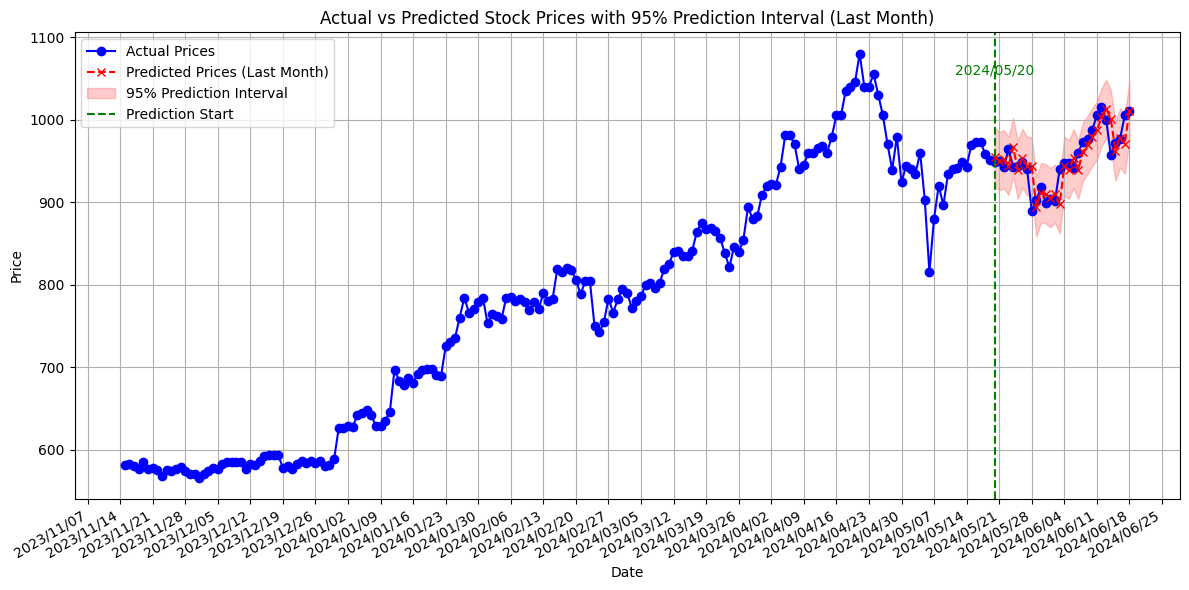

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
import matplotlib.dates as mdates

# Load the dataset
file_path = '2330-training.csv'
data = pd.read_csv(file_path)

# Preprocessing: Convert price columns from strings to floats (removing commas)
for col in ['x1', 'x2', 'x3', 'x4', 'x5', 'y']:  # Include 'y' if it also contains commas
    # Remove commas and convert to float
    data[col] = data[col].replace({',': ''}, regex=True).astype(float)

# Check the length of the data
num_rows = len(data)

# Create a date range starting from November 15, 2023 with the number of rows in the DataFrame
start_date = '2023-11-15'
data['date'] = pd.date_range(start=start_date, periods=num_rows, freq='D')

# Check for missing values (optional)
data = data.dropna()

# Split the data into features (X) and target (y)
X = data[['x1', 'x2', 'x3', 'x4', 'x5']]
y = data['y']

# Split the data into training and test sets, keeping the last month's data as the test set
# Assuming the last month consists of the last 30 rows
train_size = len(data) - 30
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Train a linear regression model (you can choose other models as well)
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the target values for the last month (X_test)
y_pred = model.predict(X_test)

# Calculate standard error for predictions
# Get residuals (difference between actual and predicted in training set)
residuals = y_train - model.predict(X_train)
residual_sum_of_squares = np.sum(residuals**2)

# Degrees of freedom for t-distribution (n - k - 1) where k is the number of features
degrees_of_freedom = X_train.shape[0] - X_train.shape[1] - 1

# Calculate the mean squared error
mse = residual_sum_of_squares / degrees_of_freedom

# Standard error of predictions
pred_std_error = np.sqrt(mse * (1 + np.diag(np.dot(np.dot(X_test, np.linalg.inv(np.dot(X_train.T, X_train))), X_test.T))))

# Get the critical value for the 95% confidence interval (two-tailed)
t_critical = stats.t.ppf(0.975, degrees_of_freedom)

# Calculate the upper and lower bounds of the prediction interval
y_pred_upper = y_pred + t_critical * pred_std_error
y_pred_lower = y_pred - t_critical * pred_std_error

# Plotting the actual vs predicted values with dates

# Create a figure
plt.figure(figsize=(12, 6))

# Plot the actual data for the entire period
plt.plot(data['date'], y, label='Actual Prices', color='blue', marker='o')

# Overlay the predicted prices for the last month with red dashed line
plt.plot(data['date'].iloc[train_size:], y_pred, label='Predicted Prices (Last Month)', color='red', linestyle='--', marker='x')

# Plot the prediction interval (confidence interval) as a shaded region
plt.fill_between(data['date'].iloc[train_size:], y_pred_lower, y_pred_upper, color='red', alpha=0.2, label='95% Prediction Interval')

# Draw a vertical line at the beginning of the prediction period (last month)
prediction_start_date = data['date'].iloc[train_size]
plt.axvline(x=prediction_start_date, color='green', linestyle='--', label='Prediction Start')

# Annotate the date at the vertical line
plt.text(prediction_start_date, plt.ylim()[1]*0.95, prediction_start_date.strftime('%Y/%m/%d'),
         color='green', ha='center', va='bottom')

# Set the x-ticks to show only once a week
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # Show ticks once a week
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))

# Rotate the date labels for better readability
plt.gcf().autofmt_xdate()

# Labels and title
plt.title('Actual vs Predicted Stock Prices with 95% Prediction Interval (Last Month)')
plt.xlabel('Date')
plt.ylabel('Price')

# Show the legend
plt.legend()

# Show grid
plt.grid(True)

# Show plot
plt.tight_layout()  # Adjust layout to fit all elements
plt.show()
